# Serbian Legal Named Entity Recognition (NER) Pipeline - 5-Fold Cross-Validation with Class Weights

This notebook implements 5-fold cross-validation for the Serbian Legal NER pipeline using the base BERT model (classla/bcms-bertic) **with class weights** to handle class imbalance.

## Key Features
- **5-Fold Cross-Validation**: Robust evaluation across different data splits
- **Base BERT Architecture**: Uses classla/bcms-bertic for token classification
- **Class Weights**: Weighted loss function to handle imbalanced entity distribution
- **Sliding Window Tokenization**: Handles long sequences without truncation
- **Comprehensive Metrics**: Precision, recall, F1-score, and accuracy tracking
- **Statistical Analysis**: Mean and standard deviation across folds

## Entity Types
- **COURT**: Court institutions
- **DECISION_DATE**: Dates of legal decisions
- **CASE_NUMBER**: Case identifiers
- **CRIMINAL_ACT**: Criminal acts/charges
- **PROSECUTOR**: Prosecutor entities
- **DEFENDANT**: Defendant entities
- **JUDGE**: Judge names
- **REGISTRAR**: Court registrar
- **SANCTION**: Sanctions/penalties
- **SANCTION_TYPE**: Type of sanction
- **SANCTION_VALUE**: Value/duration of sanction
- **PROVISION**: Legal provisions
- **PROCEDURE_COSTS**: Legal procedure costs

## 1. Environment Setup and Dependencies

In [1]:
# Install required packages
!pip install transformers torch datasets tokenizers scikit-learn seqeval pandas numpy matplotlib seaborn tqdm

In [2]:
# Import shared modules
import sys
import os

sys.path.append('/shared/')


import importlib
import shared
import shared.model_utils
import shared.data_processing
import shared.dataset
import shared.evaluation
import shared.config
importlib.reload(shared.config)
importlib.reload(shared.data_processing)
importlib.reload(shared.dataset)
importlib.reload(shared.model_utils)
importlib.reload(shared.evaluation)
importlib.reload(shared)

# Import from shared modules
from shared import (
    # Configuration
    ENTITY_TYPES, BIO_LABELS,
    get_default_model_config, setup_environment,

    # Data processing
    LabelStudioToBIOConverter, load_labelstudio_data,
    analyze_labelstudio_data, validate_bio_examples,

    # Dataset
    NERDataset, tokenize_and_align_labels_with_sliding_window,
    create_huggingface_datasets,

    # Model utilities
    load_model_and_tokenizer, create_training_arguments,
    detailed_evaluation, setup_device_and_seed,
    PerClassMetricsCallback,

    # Comprehensive tracking
    analyze_entity_distribution_per_fold,
    generate_detailed_classification_report,
    # Aggregate functions
    create_aggregate_report_across_folds
)

# Standard imports
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from transformers import DataCollatorForTokenClassification, AutoTokenizer, Trainer
from collections import Counter

# Setup device and random seed
device = setup_device_and_seed(42)

2025-10-05 15:15:48.159928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-05 15:15:48.160002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-05 15:15:48.161140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-05 15:15:48.167479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 15:15:49.147710: W tensorflow/compiler/tf2

🔧 Setup complete:
  PyTorch version: 2.1.1+cu121
  CUDA available: True
  CUDA device: NVIDIA RTX A4000
  Device: cuda
  Random seed: 42


## 2. Configuration and Environment Setup

In [3]:
# Setup environment and paths
env_setup = setup_environment(use_local=False, create_dirs=False)
paths = env_setup['paths']

# Model configuration
MODEL_NAME = "classla/bcms-bertic"
model_config = get_default_model_config()

# Output directory
OUTPUT_DIR = f"{paths['models_dir']}/bertic_base_class_weights_5fold_cv"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"🔧 Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Entity types: {len(ENTITY_TYPES)}")
print(f"  BIO labels: {len(BIO_LABELS)}")

🔧 Environment setup (cloud):
  ✅ labelstudio_json: /datasets/annotations/annotations.json
  ✅ judgments_dir: /datasets/judgments
  ✅ labelstudio_files_dir: /datasets/judgments
  ❌ mlm_data_dir: /datasets/dapt-mlm
  ✅ models_dir: /storage/models
  ✅ logs_dir: /storage/logs
  ✅ results_dir: /storage/results
🔧 Configuration:
  Model: classla/bcms-bertic
  Output directory: /storage/models/bertic_base_class_weights_5fold_cv
  Entity types: 16
  BIO labels: 33


## 3. Data Loading and Analysis

In [4]:
# Load LabelStudio data
labelstudio_data = load_labelstudio_data(paths['labelstudio_json'])

# Analyze the data
if labelstudio_data:
    analysis = analyze_labelstudio_data(labelstudio_data)
else:
    print("❌ No data loaded. Please check your paths.")
    exit()

✅ Loaded 225 annotated documents from /datasets/annotations/annotations.json
📊 Analysis Results:
Total documents: 225
Total annotations: 225
Unique entity types: 14

Entity distribution:
  DEFENDANT: 1240
  PROVISION_MATERIAL: 1177
  CRIMINAL_ACT: 792
  PROVISION_PROCEDURAL: 686
  REGISTRAR: 460
  COURT: 458
  JUDGE: 451
  PROSECUTOR: 395
  DECISION_DATE: 359
  SANCTION_TYPE: 248
  SANCTION_VALUE: 241
  VERDICT: 238
  PROCEDURE_COSTS: 231
  CASE_NUMBER: 225


## 4. Data Preprocessing and BIO Conversion

In [5]:
# Convert LabelStudio data to BIO format
converter = LabelStudioToBIOConverter(
    judgments_dir=paths['judgments_dir'],
    labelstudio_files_dir=paths.get('labelstudio_files_dir')
)

bio_examples = converter.convert_to_bio(labelstudio_data)
print(f"✅ Converted {len(bio_examples)} examples to BIO format")

# Validate BIO examples
valid_examples, stats = validate_bio_examples(bio_examples)
print(f"📊 Validation complete: {stats['valid_examples']} valid examples")

✅ Converted 225 examples to BIO format
📊 BIO Validation Results:
Total examples: 225
Valid examples: 225
Invalid examples: 0
Empty examples: 0
📊 Validation complete: 225 valid examples


## 5. Dataset Preparation

In [6]:
# Create NER dataset
ner_dataset = NERDataset(valid_examples)
prepared_examples = ner_dataset.prepare_for_training()

print(f"📊 Dataset statistics:")
print(f"  Number of unique labels: {ner_dataset.get_num_labels()}")
print(f"  Prepared examples: {len(prepared_examples)}")

# Get label statistics
label_stats = ner_dataset.get_label_statistics()
print(f"  Total tokens: {label_stats['total_tokens']}")
print(f"  Entity types found: {len(label_stats['entity_counts'])}")

📊 Dataset statistics:
  Number of unique labels: 29
  Prepared examples: 225
  Total tokens: 232475
  Entity types found: 14


## 6. Class Weights Implementation

In [7]:
# ============================================================================
# CLASS WEIGHTS FUNCTIONS
# ============================================================================

def calculate_class_weights_from_tokenized(tokenized_examples, label_to_id):
    """
    Calculate class weights based on label frequency in tokenized training data.
    
    Args:
        tokenized_examples: List of tokenized training examples (with integer label IDs)
        label_to_id: Dictionary mapping labels to IDs
    
    Returns:
        torch.Tensor: Class weights tensor
    """
    # Collect all label IDs from training examples, filtering out -100 (ignore index)
    all_label_ids = []
    for example in tokenized_examples:
        # Filter out -100 values (used for padding/subword tokens)
        valid_labels = [label for label in example['labels'] if label != -100]
        all_label_ids.extend(valid_labels)
    
    # Get unique classes that actually appear in the training data
    unique_labels_in_data = np.array(sorted(list(set(all_label_ids))))
    
    # Calculate class weights using sklearn's balanced approach for labels that appear
    class_weights_for_present = compute_class_weight(
        class_weight='balanced',
        classes=unique_labels_in_data,
        y=np.array(all_label_ids)
    )
    
    # Create full weight array for all possible labels
    num_labels = len(label_to_id)
    class_weights = np.ones(num_labels)  # Default weight of 1.0 for unseen labels
    
    # Fill in calculated weights for labels that appear in training data
    for label_id, weight in zip(unique_labels_in_data, class_weights_for_present):
        class_weights[label_id] = weight
    
    # Convert to tensor
    class_weights_tensor = torch.FloatTensor(class_weights)
    
    print(f"📊 Class weights calculated:")
    print(f"  Total label types: {num_labels}")
    print(f"  Labels present in training: {len(unique_labels_in_data)}")
    print(f"  Labels absent from training: {num_labels - len(unique_labels_in_data)}")
    print(f"  Total valid tokens: {len(all_label_ids)}")
    print(f"  Weight range: {class_weights.min():.4f} - {class_weights.max():.4f}")
    print(f"  Mean weight: {class_weights.mean():.4f}")
    
    return class_weights_tensor


class WeightedTrainer(Trainer):
    """
    Custom Trainer that uses weighted CrossEntropyLoss for handling class imbalance.
    """
    
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Compute weighted loss for token classification.
        """
        labels = inputs.get("labels")
        
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        if labels is not None:
            # Move class weights to the same device as logits
            if self.class_weights is not None:
                class_weights = self.class_weights.to(logits.device)
            else:
                class_weights = None
            
            # Create weighted loss function
            loss_fct = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)
            
            # Flatten for loss calculation
            active_loss = labels.view(-1) != -100
            active_logits = logits.view(-1, logits.shape[-1])
            active_labels = torch.where(
                active_loss,
                labels.view(-1),
                torch.tensor(loss_fct.ignore_index).type_as(labels)
            )
            
            loss = loss_fct(active_logits, active_labels)
        else:
            loss = None
        
        return (loss, outputs) if return_outputs else loss

print("✅ Class weights functions defined successfully!")

✅ Class weights functions defined successfully!


## 7. K-Fold Cross-Validation Setup

In [8]:
# Set up 5-fold cross-validation
N_FOLDS = 5
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Convert to numpy array for easier indexing
examples_array = np.array(prepared_examples, dtype=object)

print(f"Setting up {N_FOLDS}-fold cross-validation")
print(f"Total examples: {len(prepared_examples)}")
print(f"Examples per fold (approx): {len(prepared_examples) // N_FOLDS}")

# Load tokenizer (will be used across all folds)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"\nLoaded tokenizer for {MODEL_NAME}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

# Store results from all folds
fold_results = []

Setting up 5-fold cross-validation
Total examples: 225
Examples per fold (approx): 45

Loaded tokenizer for classla/bcms-bertic
Tokenizer vocab size: 32000


## 8. K-Fold Cross-Validation Helper Functions

In [9]:
# ============================================================================
# K-FOLD CROSS-VALIDATION HELPER FUNCTIONS WITH CLASS WEIGHTS
# ============================================================================

def prepare_fold_data_with_class_weights(train_examples, val_examples, tokenizer, ner_dataset):
    """
    Prepare training and validation datasets for a specific fold with class weights.

    Args:
        train_examples: Training examples for this fold
        val_examples: Validation examples for this fold
        tokenizer: Tokenizer instance
        ner_dataset: NER dataset instance

    Returns:
        tuple: (train_dataset, val_dataset, data_collator, class_weights)
    """
    # Tokenize datasets with sliding window
    train_tokenized = tokenize_and_align_labels_with_sliding_window(
        train_examples, tokenizer, ner_dataset.label_to_id,
        max_length=model_config['max_length'], stride=model_config['stride']
    )

    val_tokenized = tokenize_and_align_labels_with_sliding_window(
        val_examples, tokenizer, ner_dataset.label_to_id,
        max_length=model_config['max_length'], stride=model_config['stride']
    )

    # Calculate class weights from training data
    print("⚖️  Calculating class weights from training data...")
    class_weights = calculate_class_weights_from_tokenized(train_tokenized, ner_dataset.label_to_id)

    # Create HuggingFace datasets
    train_dataset, val_dataset, _ = create_huggingface_datasets(
        train_tokenized, val_tokenized, val_tokenized  # Using val as placeholder for test
    )

    # Data collator
    data_collator = DataCollatorForTokenClassification(
        tokenizer=tokenizer,
        padding=True,
        return_tensors="pt"
    )

    return train_dataset, val_dataset, data_collator, class_weights

print("✅ K-fold helper functions with class weights defined successfully!")

✅ K-fold helper functions with class weights defined successfully!


In [10]:
def create_model_and_weighted_trainer(fold_num, train_dataset, val_dataset, data_collator, tokenizer, ner_dataset, class_weights, device):
    """
    Create model and weighted trainer for a specific fold with comprehensive metrics tracking.

    Args:
        fold_num: Current fold number
        train_dataset: Training dataset for this fold
        val_dataset: Validation dataset for this fold
        data_collator: Data collator
        tokenizer: Tokenizer instance
        ner_dataset: NER dataset instance
        class_weights: Class weights tensor
        device: Device to use (cuda/cpu)

    Returns:
        tuple: (model, trainer, metrics_callback, fold_output_dir)
    """
    # Create fold-specific output directory
    fold_output_dir = f"{OUTPUT_DIR}/fold_{fold_num}"
    import os
    os.makedirs(fold_output_dir, exist_ok=True)

    # Load fresh model for this fold
    model, _ = load_model_and_tokenizer(
        MODEL_NAME,
        ner_dataset.get_num_labels(),
        ner_dataset.id_to_label,
        ner_dataset.label_to_id
    )

    # Move model to device
    model.to(device)

    # Create training arguments for this fold
    training_args = create_training_arguments(
        output_dir=fold_output_dir,
        num_epochs=model_config['num_epochs'],
        batch_size=model_config['batch_size'],
        learning_rate=model_config['learning_rate'],
        warmup_steps=500,
        weight_decay=0.01,
        logging_steps=50,
        eval_steps=100,
        save_steps=500,
        early_stopping_patience=3
    )

    # Create metrics callback for comprehensive tracking
    metrics_callback = PerClassMetricsCallback(id_to_label=ner_dataset.id_to_label)

    # Import compute_metrics from model_utils (not exported in __init__.py)
    from shared.model_utils import compute_metrics
    from transformers import EarlyStoppingCallback
    
    # Create compute_metrics function with id_to_label bound
    def compute_metrics_fn(eval_pred):
        return compute_metrics(eval_pred, ner_dataset.id_to_label)

    # Build callbacks list
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3), metrics_callback]

    # Create weighted trainer with class weights
    print(f"⚖️  Creating WeightedTrainer with class weights for fold {fold_num}")
    trainer = WeightedTrainer(
        class_weights=class_weights,
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_fn,
        callbacks=callbacks
    )

    print(f"Weighted trainer initialized for fold {fold_num} with comprehensive metrics tracking")
    return model, trainer, metrics_callback, fold_output_dir

print("✅ Model and weighted trainer creation function defined successfully!")

✅ Model and weighted trainer creation function defined successfully!


In [11]:
def train_and_evaluate_fold(fold_num, trainer, val_dataset, ner_dataset):
    """
    Train and evaluate a model for a specific fold.

    Args:
        fold_num: Current fold number
        trainer: Trainer instance
        val_dataset: Validation dataset for this fold
        ner_dataset: NER dataset instance

    Returns:
        dict: Fold results including metrics
    """
    print(f"\n🏋️  Training fold {fold_num} with class weights...")

    # Train the model
    trainer.train()

    print(f"💾 Saving model for fold {fold_num}...")
    trainer.save_model()

    # Evaluate on validation set
    print(f"📊 Evaluating fold {fold_num}...")
    eval_results = detailed_evaluation(
        trainer, val_dataset, f"Fold {fold_num} Validation", ner_dataset.id_to_label
    )

    # Extract metrics
    fold_result = {
        'fold': fold_num,
        'precision': eval_results['precision'],
        'recall': eval_results['recall'],
        'f1': eval_results['f1'],
        'accuracy': eval_results['accuracy'],
        'true_predictions': eval_results['true_predictions'],
        'true_labels': eval_results['true_labels']
    }

    print(f"\nFold {fold_num} completed successfully!")
    return fold_result

print("✅ Training and evaluation helper function defined successfully!")

✅ Training and evaluation helper function defined successfully!


## 9. K-Fold Cross-Validation Training Loop with Class Weights

In [12]:
# ============================================================================
# MAIN K-FOLD CROSS-VALIDATION LOOP WITH CLASS WEIGHTS
# ============================================================================

print(f"Using device: {device}")
print(f"\n{'='*80}")
print(f"STARTING 5-FOLD CROSS-VALIDATION WITH CLASS WEIGHTS")
print(f"{'='*80}")
print(f"Total examples: {len(prepared_examples)}")
print(f"Model: {MODEL_NAME}")
print(f"Device: {device}")

for fold_num, (train_idx, val_idx) in enumerate(kfold.split(examples_array), 1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold_num}/{N_FOLDS}")
    print(f"{'='*80}")
    print(f"Train indices: {len(train_idx)}, Val indices: {len(val_idx)}")
    
    # Split data for this fold
    train_examples = examples_array[train_idx].tolist()
    val_examples = examples_array[val_idx].tolist()
    
    print(f"Training examples: {len(train_examples)}")
    print(f"Validation examples: {len(val_examples)}")
    
    # Analyze entity distributions for this fold
    print(f"\n📊 Analyzing entity distributions...")
    train_dist = analyze_entity_distribution_per_fold(train_examples, f"Fold {fold_num} - Training")
    val_dist = analyze_entity_distribution_per_fold(val_examples, f"Fold {fold_num} - Validation")
    
    # Prepare data for this fold with class weights
    print(f"\n🔤 Preparing data for fold {fold_num} with class weights...")
    train_dataset, val_dataset, data_collator, class_weights = prepare_fold_data_with_class_weights(
        train_examples, val_examples, tokenizer, ner_dataset
    )
    
    print(f"📦 Fold {fold_num} datasets:")
    print(f"  Training: {len(train_dataset)} examples")
    print(f"  Validation: {len(val_dataset)} examples")
    
    # Create model and weighted trainer for this fold
    print(f"\n🤖 Creating model and weighted trainer for fold {fold_num}...")
    model, trainer, metrics_callback, fold_output_dir = create_model_and_weighted_trainer(
        fold_num, train_dataset, val_dataset, data_collator, tokenizer, ner_dataset, class_weights, device
    )
    
    # Train and evaluate this fold
    fold_result = train_and_evaluate_fold(fold_num, trainer, val_dataset, ner_dataset)
    
    # Get predictions and labels for aggregation
    print(f"\n📊 Getting predictions for fold {fold_num}...")
    predictions, labels, _ = trainer.predict(val_dataset)
    predictions = np.argmax(predictions, axis=2)
    
    # Convert to label names
    true_labels = [[ner_dataset.id_to_label[l] for l in label if l != -100] for label in labels]
    pred_labels = [[ner_dataset.id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                   for prediction, label in zip(predictions, labels)]
    
    # Generate per-class metrics and confusion matrix for this fold
    from sklearn.metrics import confusion_matrix
    flat_true = [label for seq in true_labels for label in seq]
    flat_pred = [label for seq in pred_labels for label in seq]
    all_labels = sorted(list(set(flat_true + flat_pred)))
    cm = confusion_matrix(flat_true, flat_pred, labels=all_labels)
    
    # Generate classification report for this fold
    per_class_metrics = generate_detailed_classification_report(
        true_labels, pred_labels, fold_output_dir, fold_num, "Class Weights Validation"
    )
    
    # Store comprehensive data for aggregation
    fold_result['distributions'] = {'train': train_dist, 'val': val_dist}
    fold_result['per_class_metrics'] = per_class_metrics
    fold_result['confusion_matrix'] = cm
    fold_result['labels'] = all_labels
    fold_result['training_history'] = metrics_callback.get_training_history()
    fold_results.append(fold_result)
    
    # Clean up to free memory
    del model, trainer, train_dataset, val_dataset, metrics_callback
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"\n{'='*80}")
print(f"5-FOLD CROSS-VALIDATION WITH CLASS WEIGHTS COMPLETED")
print(f"{'='*80}")

Using device: cuda

STARTING 5-FOLD CROSS-VALIDATION WITH CLASS WEIGHTS
Total examples: 225
Model: classla/bcms-bertic
Device: cuda

FOLD 1/5
Train indices: 180, Val indices: 45
Training examples: 180
Validation examples: 45

📊 Analyzing entity distributions...

📊 Entity Distribution - Fold 1 - Training
Entity Type                         Count      Percentage
------------------------------------------------------------
PROVISION_MATERIAL                   7320          35.29%
PROVISION_PROCEDURAL                 3210          15.48%
CRIMINAL_ACT                         2252          10.86%
COURT                                1641           7.91%
DEFENDANT                            1445           6.97%
SANCTION_VALUE                        956           4.61%
JUDGE                                 734           3.54%
REGISTRAR                             731           3.52%
VERDICT                               573           2.76%
PROSECUTOR                            510           2.

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
⚖️  Creating WeightedTrainer with class weights for fold 1
Weighted trainer initialized for fold 1 with comprehensive metrics tracking

🏋️  Training fold 1 with class weights...


wandb: Currently logged in as: pericapero1 (pericapero1-faculty-of-). Use `wandb login --relogin` to force relogin


You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,3.239400,3.062087,0.006607,0.163319,0.012700,0.121203
200,2.311400,1.855129,0.024396,0.510042,0.046565,0.304402
300,1.241000,0.834970,0.137174,0.703488,0.229582,0.764837
400,0.559500,0.423714,0.193862,0.757928,0.308752,0.800342
500,0.229200,0.343967,0.289330,0.809725,0.426325,0.881541
600,0.143800,0.350392,0.373199,0.821353,0.513210,0.926937
700,0.102900,0.354245,0.381944,0.813953,0.519919,0.924382
800,0.084600,0.355393,0.410458,0.829810,0.549239,0.936170


💾 Saving model for fold 1...
📊 Evaluating fold 1...



📊 Fold 1 Validation Set Results:
  Precision: 0.2893
  Recall: 0.8097
  F1-score: 0.4263
  Accuracy: 0.8815

Fold 1 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.11      1.00      0.20        45
               B-COURT       0.52      1.00      0.69        99
        B-CRIMINAL_ACT       0.43      1.00      0.60       215
       B-DECISION_DATE       0.20      1.00      0.33        81
           B-DEFENDANT       0.40      0.96      0.57       332
               B-JUDGE       0.49      0.99      0.65        94
     B-PROCEDURE_COSTS       0.56      1.00      0.72        67
          B-PROSECUTOR       0.13      0.61      0.21       100
  B-PROVISION_MATERIAL       0.71      0.97      0.82       347
B-PROVISION_PROCEDURAL       0.78      0.95      0.86       182
           B-REGISTRAR       0.47      0.97      0.63       102
       B-SANCTION_TYPE       0.34      1.00      0.51        76
 


Class Weights Validation - Fold 1 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.1117    1.0000    0.2009        45
               B-COURT     0.5238    1.0000    0.6875        99
        B-CRIMINAL_ACT     0.4297    0.9953    0.6003       215
       B-DECISION_DATE     0.2000    1.0000    0.3333        81
           B-DEFENDANT     0.4028    0.9608    0.5676       332
               B-JUDGE     0.4869    0.9894    0.6526        94
     B-PROCEDURE_COSTS     0.5630    1.0000    0.7204        67
          B-PROSECUTOR     0.1284    0.6100    0.2122       100
  B-PROVISION_MATERIAL     0.7131    0.9741    0.8234       347
B-PROVISION_PROCEDURAL     0.7793    0.9505    0.8564       182
           B-REGISTRAR     0.4692    0.9706    0.6326       102
       B-SANCTION_TYPE     0.3439    1.0000    0.5118        76
      B-SANCTION_VALUE     0.3771    0.9041    0.5323        73
             B-VERDICT     0.3

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
⚖️  Creating WeightedTrainer with class weights for fold 2
Weighted trainer initialized for fold 2 with comprehensive metrics tracking

🏋️  Training fold 2 with class weights...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,3.228100,3.011989,0.009367,0.261591,0.018087,0.048371
200,2.393800,1.912418,0.026135,0.606754,0.050112,0.162257
300,1.245200,0.801805,0.088990,0.730967,0.158663,0.659321
400,0.551800,0.295914,0.193298,0.812250,0.312280,0.813966
500,0.282600,0.173625,0.263889,0.837436,0.401317,0.880659
600,0.209000,0.155041,0.337509,0.817401,0.477752,0.916579
700,0.115000,0.151040,0.422905,0.866629,0.568425,0.936333
800,0.108800,0.144625,0.450088,0.882656,0.596172,0.939904


💾 Saving model for fold 2...
📊 Evaluating fold 2...



📊 Fold 2 Validation Set Results:
  Precision: 0.2639
  Recall: 0.8374
  F1-score: 0.4013
  Accuracy: 0.8807

Fold 2 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.15      1.00      0.26        45
               B-COURT       0.57      0.99      0.73        96
        B-CRIMINAL_ACT       0.36      0.97      0.53       214
       B-DECISION_DATE       0.20      1.00      0.33        76
           B-DEFENDANT       0.34      0.99      0.51       277
               B-JUDGE       0.44      1.00      0.61        93
     B-PROCEDURE_COSTS       0.53      0.91      0.67        53
          B-PROSECUTOR       0.18      0.84      0.30        83
  B-PROVISION_MATERIAL       0.52      0.97      0.68       317
B-PROVISION_PROCEDURAL       0.77      0.97      0.86       191
           B-REGISTRAR       0.22      0.98      0.37        96
       B-SANCTION_TYPE       0.43      0.98      0.59        64
 


Class Weights Validation - Fold 2 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.1480    1.0000    0.2579        45
               B-COURT     0.5723    0.9896    0.7252        96
        B-CRIMINAL_ACT     0.3636    0.9720    0.5293       214
       B-DECISION_DATE     0.1984    1.0000    0.3312        76
           B-DEFENDANT     0.3447    0.9892    0.5112       277
               B-JUDGE     0.4429    1.0000    0.6139        93
     B-PROCEDURE_COSTS     0.5275    0.9057    0.6667        53
          B-PROSECUTOR     0.1809    0.8434    0.2979        83
  B-PROVISION_MATERIAL     0.5248    0.9685    0.6807       317
B-PROVISION_PROCEDURAL     0.7708    0.9686    0.8585       191
           B-REGISTRAR     0.2243    0.9792    0.3650        96
       B-SANCTION_TYPE     0.4257    0.9844    0.5943        64
      B-SANCTION_VALUE     0.4101    0.9194    0.5672        62
             B-VERDICT     0.4

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
⚖️  Creating WeightedTrainer with class weights for fold 3
Weighted trainer initialized for fold 3 with comprehensive metrics tracking

🏋️  Training fold 3 with class weights...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,3.218700,3.056637,0.008410,0.240283,0.016250,0.047128
200,2.395500,1.979064,0.022019,0.528269,0.042275,0.159960
300,1.315700,0.874997,0.079830,0.664311,0.142532,0.663631
400,0.531000,0.358093,0.214096,0.806832,0.338397,0.840349
500,0.277600,0.246123,0.275726,0.822144,0.412957,0.884151
600,0.157100,0.252144,0.331646,0.848645,0.476915,0.916558
700,0.123500,0.256211,0.411344,0.879859,0.560600,0.938968
800,0.099000,0.264171,0.423088,0.882803,0.572028,0.940967


💾 Saving model for fold 3...
📊 Evaluating fold 3...



📊 Fold 3 Validation Set Results:
  Precision: 0.2757
  Recall: 0.8221
  F1-score: 0.4130
  Accuracy: 0.8842

Fold 3 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.15      1.00      0.26        46
               B-COURT       0.69      0.98      0.81       100
        B-CRIMINAL_ACT       0.61      0.93      0.74       180
       B-DECISION_DATE       0.21      1.00      0.35        79
           B-DEFENDANT       0.38      0.98      0.55       244
               B-JUDGE       0.57      0.98      0.72        95
     B-PROCEDURE_COSTS       0.43      0.96      0.59        69
          B-PROSECUTOR       0.15      0.94      0.25        87
  B-PROVISION_MATERIAL       0.56      0.99      0.71       304
B-PROVISION_PROCEDURAL       0.87      0.99      0.93       174
           B-REGISTRAR       0.26      0.98      0.41        97
       B-SANCTION_TYPE       0.29      0.92      0.44        77
 


Class Weights Validation - Fold 3 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.1508    1.0000    0.2621        46
               B-COURT     0.6853    0.9800    0.8066       100
        B-CRIMINAL_ACT     0.6065    0.9333    0.7352       180
       B-DECISION_DATE     0.2090    1.0000    0.3457        79
           B-DEFENDANT     0.3814    0.9754    0.5484       244
               B-JUDGE     0.5671    0.9789    0.7181        95
     B-PROCEDURE_COSTS     0.4314    0.9565    0.5946        69
          B-PROSECUTOR     0.1472    0.9425    0.2547        87
  B-PROVISION_MATERIAL     0.5597    0.9868    0.7143       304
B-PROVISION_PROCEDURAL     0.8731    0.9885    0.9272       174
           B-REGISTRAR     0.2582    0.9794    0.4086        97
       B-SANCTION_TYPE     0.2851    0.9221    0.4356        77
      B-SANCTION_VALUE     0.2946    0.9726    0.4522        73
             B-VERDICT     0.4

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
⚖️  Creating WeightedTrainer with class weights for fold 4
Weighted trainer initialized for fold 4 with comprehensive metrics tracking

🏋️  Training fold 4 with class weights...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,3.206500,3.036279,0.008086,0.250716,0.015666,0.043941
200,2.343400,1.950896,0.022690,0.594734,0.043711,0.157400
300,1.258800,0.894092,0.083469,0.702919,0.149219,0.694738
400,0.607600,0.368779,0.197408,0.828277,0.318828,0.837216
500,0.252400,0.216486,0.269449,0.842587,0.408322,0.894285
600,0.180800,0.194554,0.333106,0.838008,0.476718,0.919602
700,0.133700,0.183944,0.380243,0.861477,0.527607,0.933231
800,0.108000,0.168656,0.433095,0.900401,0.584867,0.944047


💾 Saving model for fold 4...
📊 Evaluating fold 4...



📊 Fold 4 Validation Set Results:
  Precision: 0.2694
  Recall: 0.8426
  F1-score: 0.4083
  Accuracy: 0.8943

Fold 4 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.15      1.00      0.26        44
               B-COURT       0.57      1.00      0.72        97
        B-CRIMINAL_ACT       0.42      1.00      0.59       214
       B-DECISION_DATE       0.18      1.00      0.31        83
           B-DEFENDANT       0.33      0.95      0.49       316
               B-JUDGE       0.54      0.96      0.69        95
     B-PROCEDURE_COSTS       0.32      0.94      0.48        49
          B-PROSECUTOR       0.14      1.00      0.25        68
  B-PROVISION_MATERIAL       0.74      0.95      0.83       312
B-PROVISION_PROCEDURAL       0.76      0.97      0.85       166
           B-REGISTRAR       0.24      1.00      0.39        97
       B-SANCTION_TYPE       0.36      0.97      0.53        69
 


Class Weights Validation - Fold 4 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.1462    1.0000    0.2551        44
               B-COURT     0.5673    1.0000    0.7239        97
        B-CRIMINAL_ACT     0.4243    0.9953    0.5950       214
       B-DECISION_DATE     0.1800    1.0000    0.3051        83
           B-DEFENDANT     0.3304    0.9525    0.4906       316
               B-JUDGE     0.5449    0.9579    0.6947        95
     B-PROCEDURE_COSTS     0.3239    0.9388    0.4817        49
          B-PROSECUTOR     0.1450    1.0000    0.2533        68
  B-PROVISION_MATERIAL     0.7357    0.9455    0.8275       312
B-PROVISION_PROCEDURAL     0.7559    0.9699    0.8496       166
           B-REGISTRAR     0.2389    1.0000    0.3857        97
       B-SANCTION_TYPE     0.3602    0.9710    0.5255        69
      B-SANCTION_VALUE     0.3403    0.9848    0.5058        66
             B-VERDICT     0.3

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model (parameters: 110,049,053)
🖥️  Device: cuda
⚙️  Training configuration:
  Epochs: 8
  Batch size: 8
  Learning rate: 3e-05
  Warmup steps: 500
  Weight decay: 0.01
  Early stopping patience: 3
⚖️  Creating WeightedTrainer with class weights for fold 5
Weighted trainer initialized for fold 5 with comprehensive metrics tracking

🏋️  Training fold 5 with class weights...


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,3.213400,3.054437,0.008708,0.269770,0.016871,0.043139
200,2.350400,1.925286,0.024011,0.606282,0.046193,0.176963
300,1.221600,0.851598,0.081488,0.683118,0.145607,0.686069
400,0.518800,0.316718,0.232972,0.807628,0.361627,0.866982
500,0.245400,0.223114,0.298638,0.823892,0.438377,0.908320
600,0.137900,0.216415,0.288816,0.790802,0.423106,0.911116
700,0.111300,0.256248,0.417777,0.862030,0.562798,0.943766
800,0.091200,0.251323,0.432559,0.877734,0.579522,0.947115


💾 Saving model for fold 5...
📊 Evaluating fold 5...



📊 Fold 5 Validation Set Results:
  Precision: 0.2986
  Recall: 0.8239
  F1-score: 0.4384
  Accuracy: 0.9083

Fold 5 Validation Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER       0.16      1.00      0.28        43
               B-COURT       0.73      0.99      0.84       103
        B-CRIMINAL_ACT       0.43      0.98      0.59       196
       B-DECISION_DATE       0.20      1.00      0.34        77
           B-DEFENDANT       0.36      0.99      0.52       306
               B-JUDGE       0.49      0.92      0.64        98
     B-PROCEDURE_COSTS       0.52      0.99      0.68        72
          B-PROSECUTOR       0.20      0.80      0.32       123
  B-PROVISION_MATERIAL       0.78      0.98      0.87       282
B-PROVISION_PROCEDURAL       0.88      0.97      0.92       198
           B-REGISTRAR       0.24      1.00      0.39        97
       B-SANCTION_TYPE       0.30      0.96      0.46        55
 


Class Weights Validation - Fold 5 Set - Detailed Classification Report:
                        precision    recall  f1-score   support

         B-CASE_NUMBER     0.1623    1.0000    0.2792        43
               B-COURT     0.7286    0.9903    0.8395       103
        B-CRIMINAL_ACT     0.4260    0.9847    0.5948       196
       B-DECISION_DATE     0.2021    1.0000    0.3362        77
           B-DEFENDANT     0.3556    0.9902    0.5233       306
               B-JUDGE     0.4918    0.9184    0.6406        98
     B-PROCEDURE_COSTS     0.5221    0.9861    0.6827        72
          B-PROSECUTOR     0.2016    0.8049    0.3225       123
  B-PROVISION_MATERIAL     0.7753    0.9787    0.8652       282
B-PROVISION_PROCEDURAL     0.8807    0.9697    0.9231       198
           B-REGISTRAR     0.2431    1.0000    0.3911        97
       B-SANCTION_TYPE     0.2994    0.9636    0.4569        55
      B-SANCTION_VALUE     0.2941    0.9821    0.4527        56
             B-VERDICT     0.4

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

## 10. Aggregate Results Across Folds

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f06282fb710>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f065c9da5d0, raw_cell="# ================================================.." store_history=True silent=False shell_futures=True cell_id=41ca9d46-61d4-4035-b1d0-fd8f53042b90>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given


GENERATING AGGREGATE REPORT ACROSS ALL 5 FOLDS

CREATING AGGREGATE REPORT ACROSS 5 FOLDS

📊 Plotting entity distribution across folds...

PLOTTING ENTITY DISTRIBUTION ACROSS 5 FOLDS


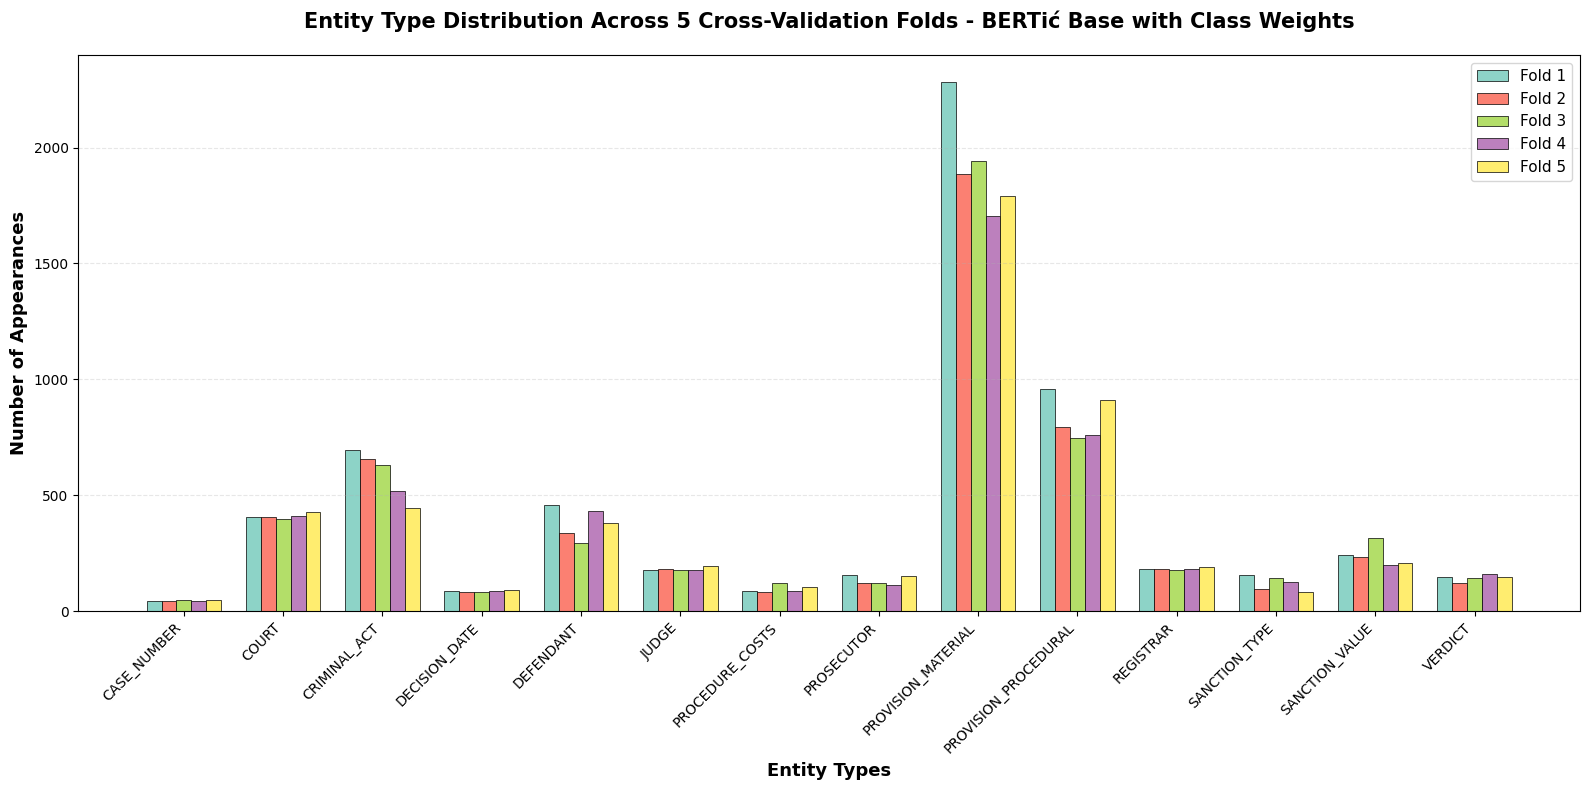

✅ Entity distribution across folds visualization displayed

📉 Plotting training and validation loss...

PLOTTING TRAINING AND VALIDATION LOSS ACROSS 5 FOLDS


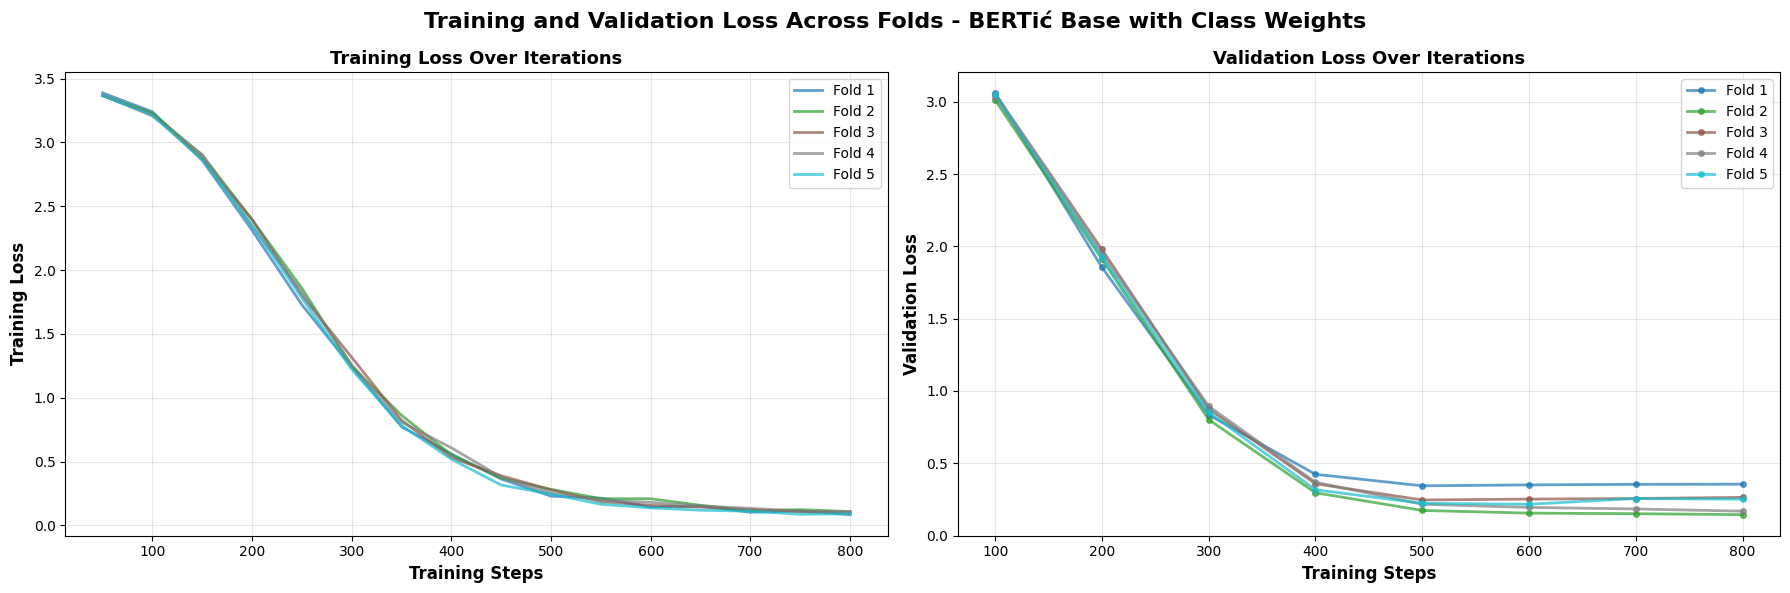

✅ Training and validation loss visualization displayed

📈 Plotting macro/micro-averaged metrics over iterations...

PLOTTING MACRO/MICRO-AVERAGED METRICS OVER ITERATIONS
📊 Aligning 8 evaluation points across 5 folds


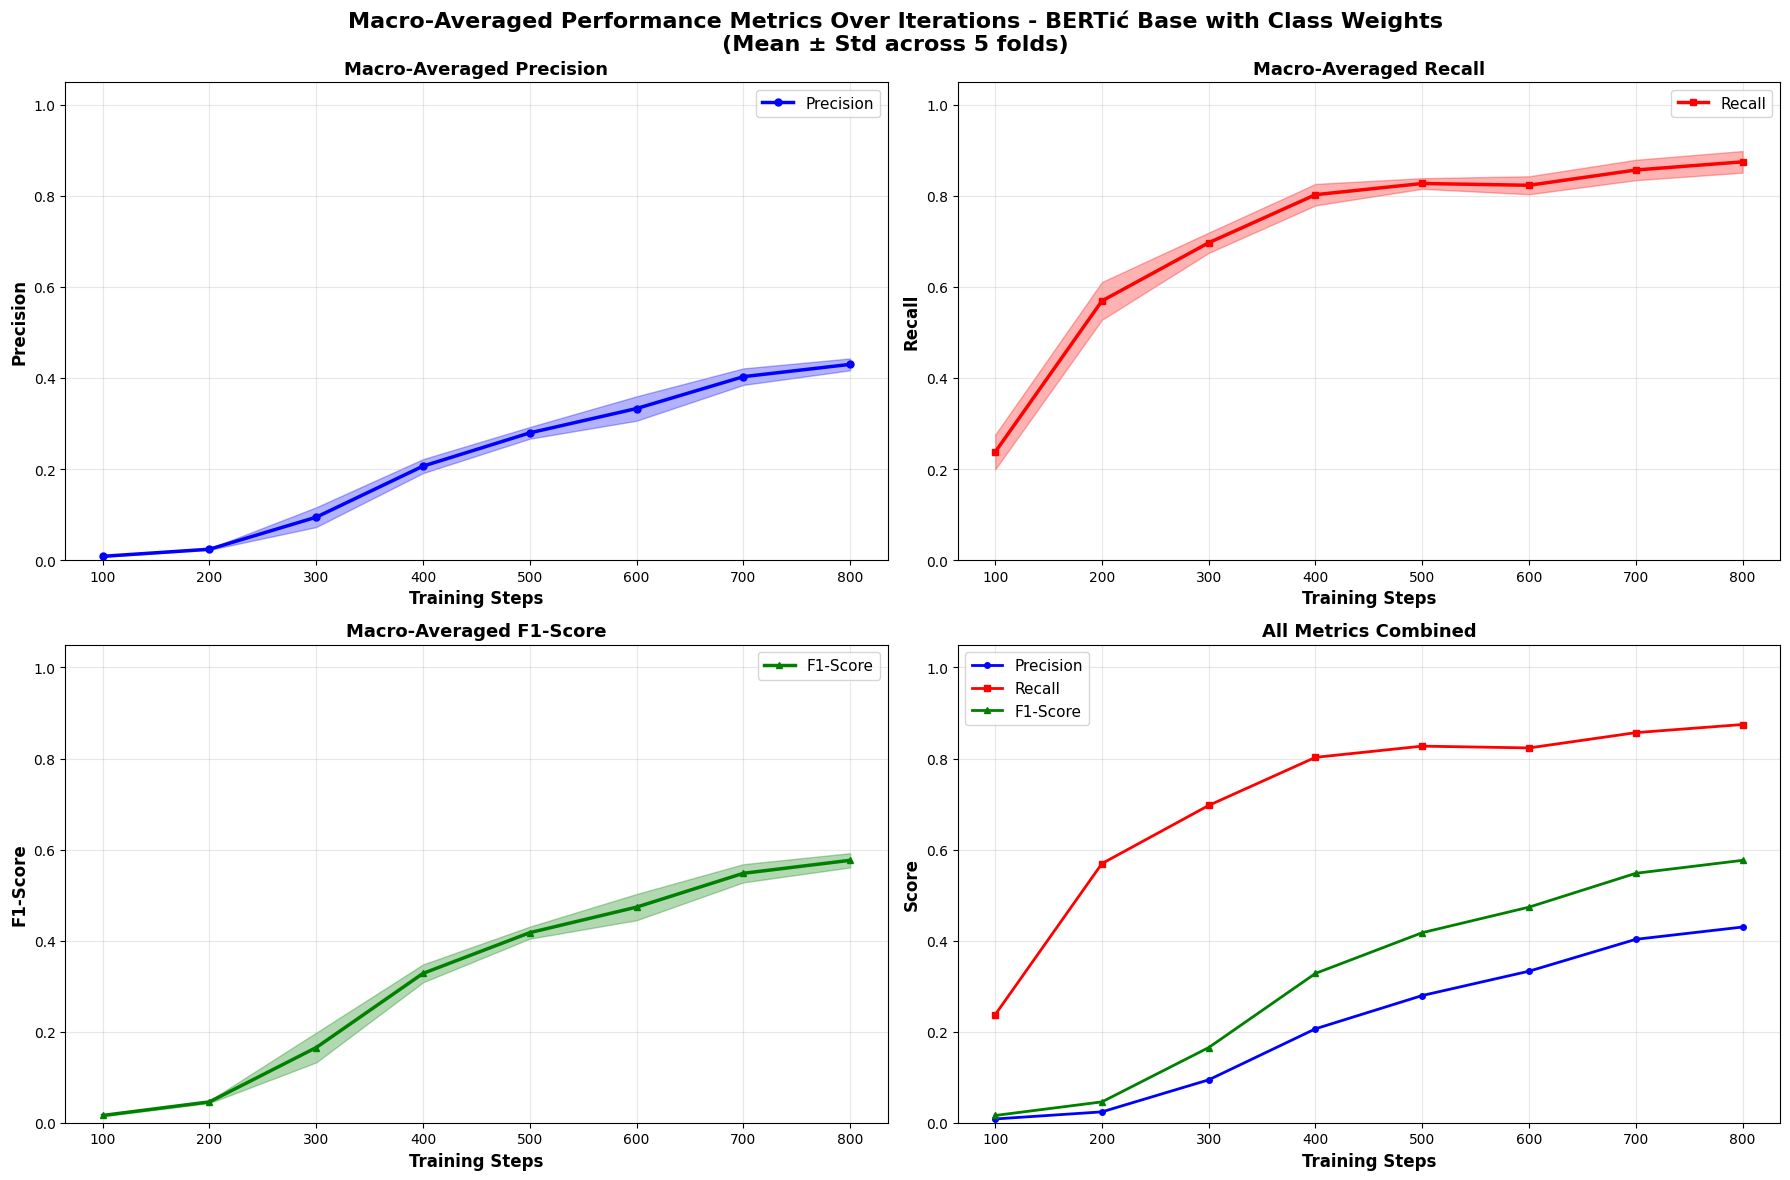

✅ Macro/micro-averaged metrics visualization displayed

📈 Aggregating training metrics...

AGGREGATING TRAINING METRICS ACROSS 5 FOLDS
📊 Aligning 8 evaluation points across 5 folds


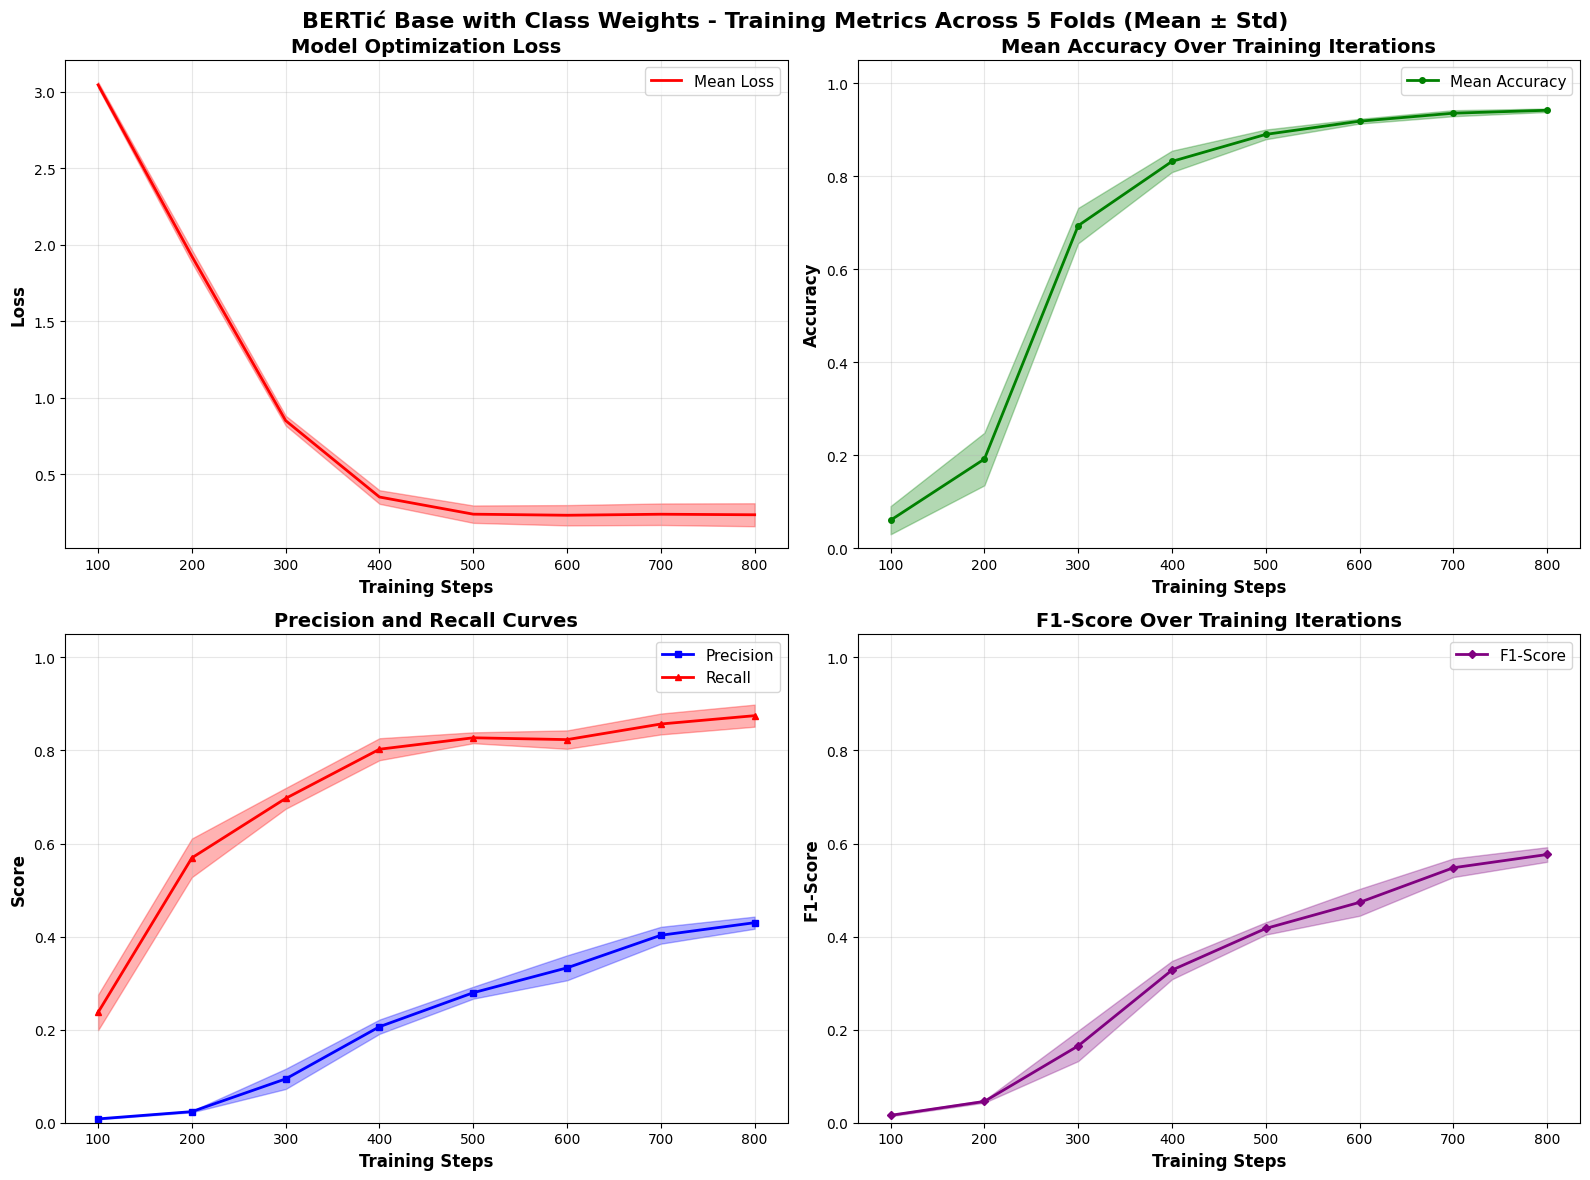

✅ Aggregate training metrics visualization displayed

📊 Aggregating per-class metrics...

AGGREGATING PER-CLASS METRICS ACROSS 5 FOLDS

BERTić Base with Class Weights - Aggregated Classification Report (Mean ± Std)

Label                           Precision          Recall        F1-Score      Support
-------------------------------------------------------------------------------------
B-CASE_NUMBER               0.1438±0.0170   1.0000±0.0000   0.2510±0.0264         45±1
B-COURT                     0.6154±0.0778   0.9920±0.0075   0.7565±0.0569         99±2
B-CRIMINAL_ACT              0.4500±0.0820   0.9761±0.0231   0.6109±0.0675       204±14
B-DECISION_DATE             0.1979±0.0096   1.0000±0.0000   0.3303±0.0135         79±3
B-DEFENDANT                 0.3630±0.0260   0.9736±0.0150   0.5282±0.0272       295±31
B-JUDGE                     0.5067±0.0443   0.9689±0.0288   0.6640±0.0376         95±2
B-PROCEDURE_COSTS           0.4736±0.0865   0.9574±0.0337   0.6292±0.0843         62±9
B-

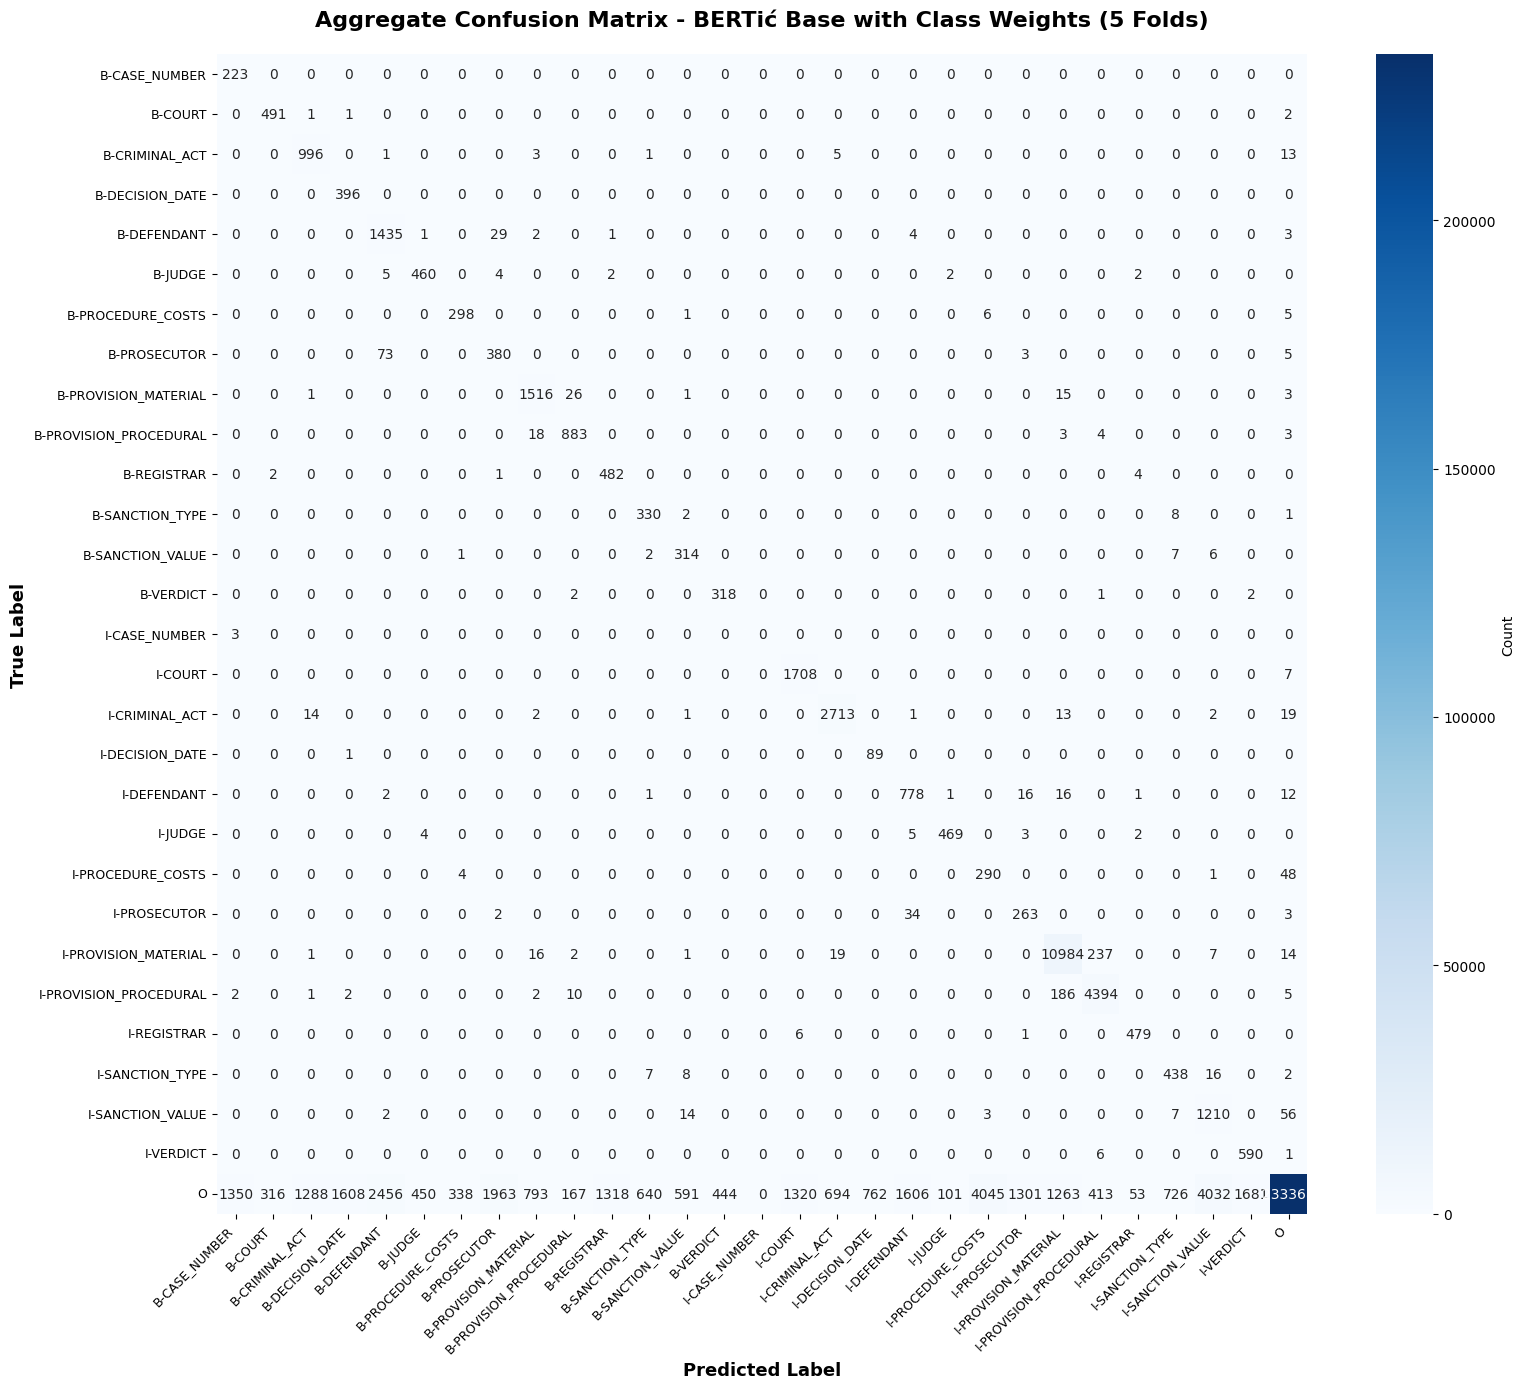

✅ Aggregate confusion matrix visualization displayed

📈 Aggregating F1 per class over iterations...

AGGREGATING F1 PER CLASS OVER ITERATIONS
⚠️  No per-class metrics found in training histories
ℹ️  This is normal if PerClassMetricsCallback didn't have access to model/eval_dataset during training
ℹ️  Per-class metrics are still available in the final classification report
ℹ️  Skipping F1 per class over iterations plot

✅ Aggregate report completed!

All visualizations displayed in notebook above.

FINAL RESULTS - BERTić Base with Class Weights (5-Fold CV)

Overall Metrics (Mean ± Std):
  Precision: 0.2794 ± 0.0128
  Recall:    0.8272 ± 0.0117
  F1-score:  0.4175 ± 0.0133
  Accuracy:  0.8898 ± 0.0105

💾 Saved aggregate report to /storage/models/bertic_base_class_weights_5fold_cv/aggregate_report.json

✅ All results saved to: /storage/models/bertic_base_class_weights_5fold_cv

📊 All visualizations displayed in notebook above.
Error in callback <bound method _WandbInit._pause_backend of <

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [13]:
# ============================================================================
# AGGREGATE RESULTS ACROSS ALL FOLDS
# ============================================================================

print(f"\n{'='*80}")
print(f"GENERATING AGGREGATE REPORT ACROSS ALL {N_FOLDS} FOLDS")
print(f"{'='*80}")

# Create aggregate report with all visualizations displayed in notebook
aggregate_report = create_aggregate_report_across_folds(
    fold_results=fold_results,
    model_name="BERTić Base with Class Weights",
    display=True
)

# Calculate overall metrics from fold results
precisions = [fold['precision'] for fold in fold_results]
recalls = [fold['recall'] for fold in fold_results]
f1_scores = [fold['f1'] for fold in fold_results]
accuracies = [fold['accuracy'] for fold in fold_results]

# Print summary
print(f"\n{'='*80}")
print(f"FINAL RESULTS - BERTić Base with Class Weights ({N_FOLDS}-Fold CV)")
print(f"{'='*80}")
print(f"\nOverall Metrics (Mean ± Std):")
print(f"  Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"  Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"  F1-score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"  Accuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

# Save aggregate report
import json
aggregate_report_path = f"{OUTPUT_DIR}/aggregate_report.json"
with open(aggregate_report_path, 'w') as f:
    json.dump({
        'model_name': 'BERTić Base with Class Weights',
        'n_folds': N_FOLDS,
        'overall_metrics': {
            'precision_mean': float(np.mean(precisions)),
            'precision_std': float(np.std(precisions)),
            'recall_mean': float(np.mean(recalls)),
            'recall_std': float(np.std(recalls)),
            'f1_mean': float(np.mean(f1_scores)),
            'f1_std': float(np.std(f1_scores)),
            'accuracy_mean': float(np.mean(accuracies)),
            'accuracy_std': float(np.std(accuracies))
        },
        'fold_results': fold_results
    }, f, indent=2, default=str)
print(f"\n💾 Saved aggregate report to {aggregate_report_path}")

print(f"\n✅ All results saved to: {OUTPUT_DIR}")
print(f"\n📊 All visualizations displayed in notebook above.")